In [867]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.layers import Dropout

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators**

# DATA COLLECTION

In [868]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='D8JHWTNSXO7M9VKV', output_format='pandas')

In [866]:
data = ts.get_intraday(symbol='MSFT',interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

,open,high,low,close,volume
date,,,,,
2021-07-09 20:00:00,277.8000,277.94,277.8000,277.94,1600.0
2021-07-09 19:45:00,277.8000,277.80,277.7900,277.79,1233.0
2021-07-09 19:30:00,277.7900,277.80,277.7900,277.80,1053.0
2021-07-09 19:15:00,277.7800,277.78,277.7800,277.78,220.0
2021-07-09 19:00:00,277.7499,277.75,277.7499,277.75,1611.0
...,...,...,...,...,...
2021-06-01 05:45:00,251.3000,251.30,251.2900,251.29,598.0
2021-06-01 05:00:00,251.0000,251.35,251.0000,251.35,674.0
2021-06-01 04:45:00,250.9900,250.99,250.9900,250.99,297.0


# INDICATORS CALCULATION

In [704]:
from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key='D8JHWTNSXO7M9VKV', output_format='pandas')

## 1. Rate of Change (ROC)

In [757]:
indicator_roc = ti.get_roc(symbol='MSFT', interval='15min', time_period=20)
indicator_roc = indicator_roc[0]
indicator_roc

,ROC
date,
2021-06-01 10:15:00,-0.9117
2021-06-01 10:30:00,-0.8731
2021-06-01 10:45:00,-0.9164
2021-06-01 11:00:00,-1.3527
2021-06-01 11:15:00,-1.2615
...,...
2021-07-09 19:00:00,0.1406
2021-07-09 19:15:00,0.2563
2021-07-09 19:30:00,0.2345


## 2. Simple Moving Average (SMA)

In [758]:
indicator_sma = ti.get_sma(symbol='MSFT', interval='15min', time_period=20)
indicator_sma = indicator_sma[0]
indicator_sma

,SMA
date,
2021-06-01 10:00:00,250.7222
2021-06-01 10:15:00,250.6077
2021-06-01 10:30:00,250.4982
2021-06-01 10:45:00,250.3832
2021-06-01 11:00:00,250.2132
...,...
2021-07-09 19:00:00,277.6570
2021-07-09 19:15:00,277.6925
2021-07-09 19:30:00,277.7250


## 3. Relative Strength Index (RSI)

In [759]:
indicator_rsi = ti.get_rsi(symbol='MSFT', interval='15min', time_period=20)
indicator_rsi = indicator_rsi[0]
indicator_rsi

,RSI
date,
2021-06-01 10:15:00,31.2030
2021-06-01 10:30:00,29.9604
2021-06-01 10:45:00,30.5668
2021-06-01 11:00:00,26.9342
2021-06-01 11:15:00,28.9753
...,...
2021-07-09 19:00:00,53.8171
2021-07-09 19:15:00,54.1876
2021-07-09 19:30:00,54.4440


## 4. Bolling Bands (BBANDS)

In [760]:
indicator_bb = ti.get_bbands(symbol='MSFT', interval='15min', time_period=20)
indicator_bb = indicator_bb[0]
indicator_bb

,Real Middle Band,Real Upper Band,Real Lower Band
date,,,
2021-07-09 20:00:00,277.7805,278.1902,277.3708
2021-07-09 19:45:00,277.7525,278.1904,277.3146
2021-07-09 19:30:00,277.7250,278.2159,277.2341
2021-07-09 19:15:00,277.6925,278.2418,277.1432
2021-07-09 19:00:00,277.6570,278.2674,277.0466
...,...,...,...
2021-06-01 11:00:00,250.2132,252.0298,248.3966
2021-06-01 10:45:00,250.3832,251.9383,248.8281
2021-06-01 10:30:00,250.4982,251.8641,249.1323


**Merge indicators to data**

In [761]:
# original_df = pd.merge(data, indicator_roc, on='date', how='inner')
# original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
# original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
# original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
# original_df = original_df.iloc[::-1]
# original_df.to_csv('./DATA/MSFT.csv')
# original_df

,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Upper Band,Real Lower Band
date,,,,,,,,,,,
2021-06-01 10:15:00,250.0100,250.06,248.8700,248.88,815307.0,-0.9117,250.6077,31.2030,250.6077,251.6797,249.5357
2021-06-01 10:30:00,248.8700,248.87,247.9100,248.64,1142659.0,-0.8731,250.4982,29.9604,250.4982,251.8641,249.1323
2021-06-01 10:45:00,248.6500,249.13,248.5400,248.69,822538.0,-0.9164,250.3832,30.5668,250.3832,251.9383,248.8281
2021-06-01 11:00:00,248.6600,248.90,247.6800,247.95,850538.0,-1.3527,250.2132,26.9342,250.2132,252.0298,248.3966
2021-06-01 11:15:00,247.9400,250.50,247.6700,248.12,1663982.0,-1.2615,250.0547,28.9753,250.0547,252.0153,248.0941
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-09 19:00:00,277.7499,277.75,277.7499,277.75,1611.0,0.1406,277.6570,53.8171,277.6570,278.2674,277.0466
2021-07-09 19:15:00,277.7800,277.78,277.7800,277.78,220.0,0.2563,277.6925,54.1876,277.6925,278.2418,277.1432
2021-07-09 19:30:00,277.7900,277.80,277.7900,277.80,1053.0,0.2345,277.7250,54.4440,277.7250,278.2159,277.2341


# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [762]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[248.88],
       [248.64],
       [248.69],
       ...,
       [277.8 ],
       [277.79],
       [277.94]])

In [763]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645],
       [0.14742903],
       [0.14876808],
       ...,
       [0.92836101],
       [0.9280932 ],
       [0.93211034]])

In [764]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [765]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 1)
Size validate:  (157, 60, 1)
Size test:  (157, 60, 1)


### b. Train Model

In [766]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

Epoch 1/20
40/40 [==============================] - 9s 107ms/step - loss: 0.0688 - val_loss: 0.0236
Epoch 2/20
40/40 [==============================] - 3s 66ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/20
40/40 [==============================] - 2s 59ms/step - loss: 4.1703e-04 - val_loss: 5.1874e-04
Epoch 4/20
40/40 [==============================] - 2s 60ms/step - loss: 4.0173e-04 - val_loss: 6.3883e-04
Epoch 5/20
40/40 [==============================] - 2s 55ms/step - loss: 3.9625e-04 - val_loss: 7.9483e-04
Epoch 6/20
40/40 [==============================] - 2s 57ms/step - loss: 4.0202e-04 - val_loss: 5.6985e-04
Epoch 7/20
40/40 [==============================] - 2s 56ms/step - loss: 4.1067e-04 - val_loss: 4.1388e-04
Epoch 8/20
40/40 [==============================] - 2s 60ms/step - loss: 4.0082e-04 - val_loss: 6.0921e-04
Epoch 9/20
40/40 [==============================] - 2s 60ms/step - loss: 4.2079e-04 - val_loss: 4.4360e-04
Epoch 10/20
40/40 [==============================] -

### c. Test Model

In [767]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [768]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [769]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-769-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Upper Band,Real Lower Band,predictions
1476,2021-07-07 11:30:00,278.8400,278.97,278.5500,278.9300,624508.0,-0.0681,279.1518,51.1594,279.1518,279.8108,278.4927,279.347778
1477,2021-07-07 11:45:00,278.9450,279.35,278.5200,279.3314,570070.0,0.1188,279.1683,54.7801,279.1683,279.8279,278.5087,279.311493
1478,2021-07-07 12:00:00,279.3200,279.98,279.3200,279.6900,510257.0,0.1576,279.1903,57.7271,279.1903,279.8876,278.4930,279.296082
1479,2021-07-07 12:15:00,279.7050,280.23,279.6600,280.0300,527682.0,0.3045,279.2328,60.3087,279.2328,280.0202,278.4454,279.316132
1480,2021-07-07 12:30:00,280.0500,280.24,279.7000,279.7200,661221.0,0.1575,279.2548,56.9696,279.2548,280.0703,278.4393,279.377991
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,2021-07-09 19:00:00,277.7499,277.75,277.7499,277.7500,1611.0,0.1406,277.6570,53.8171,277.6570,278.2674,277.0466,277.962341
1629,2021-07-09 19:15:00,277.7800,277.78,277.7800,277.7800,220.0,0.2563,277.6925,54.1876,277.6925,278.2418,277.1432,277.955170
1630,2021-07-09 19:30:00,277.7900,277.80,277.7900,277.8000,1053.0,0.2345,277.7250,54.4440,277.7250,278.2159,277.2341,277.947815
1631,2021-07-09 19:45:00,277.8000,277.80,277.7900,277.7900,1233.0,0.1984,277.7525,54.2841,277.7525,278.1904,277.3146,277.941833


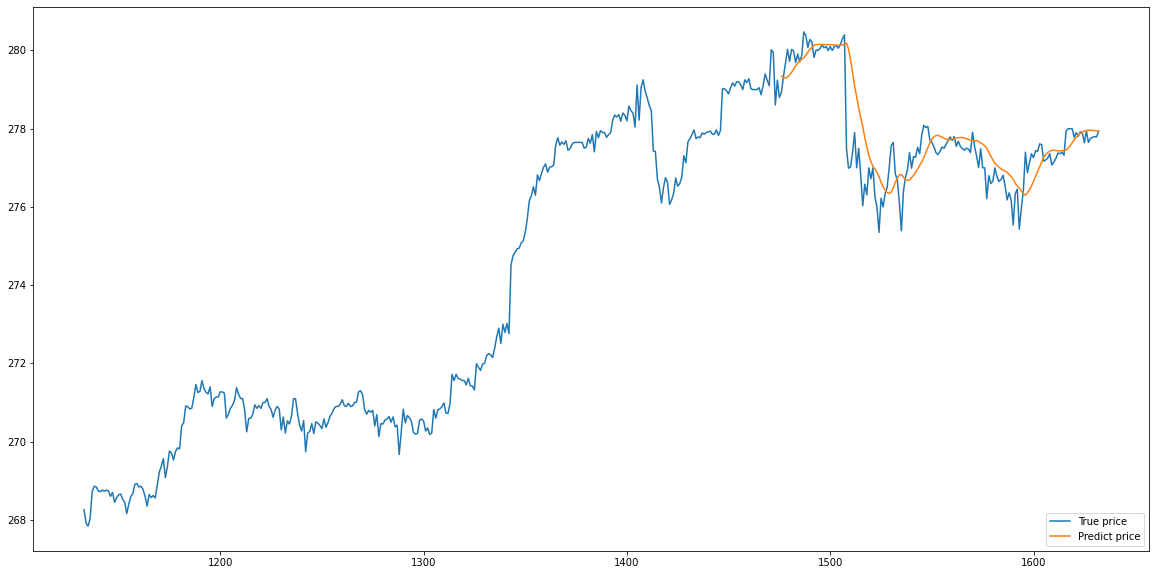

In [771]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-500:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [772]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 2.4888e+02, -9.1170e-01],
       [ 2.4864e+02, -8.7310e-01],
       [ 2.4869e+02, -9.1640e-01],
       ...,
       [ 2.7780e+02,  2.3450e-01],
       [ 2.7779e+02,  1.9840e-01],
       [ 2.7794e+02,  2.0190e-01]])

In [773]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645, 0.21469751],
       [0.14742903, 0.22363455],
       [0.14876808, 0.21360932],
       ...,
       [0.92836101, 0.48007687],
       [0.9280932 , 0.47171865],
       [0.93211034, 0.472529  ]])

In [774]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [775]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 2)
Size validate:  (157, 60, 2)
Size test:  (157, 60, 2)


In [776]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
40/40 [==============================] - 7s 88ms/step - loss: 0.0871 - val_loss: 0.0095
Epoch 2/20
40/40 [==============================] - 2s 50ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 3/20
40/40 [==============================] - 2s 58ms/step - loss: 5.0512e-04 - val_loss: 0.0011
Epoch 4/20
40/40 [==============================] - 2s 52ms/step - loss: 3.8360e-04 - val_loss: 7.3302e-04
Epoch 5/20
40/40 [==============================] - 2s 52ms/step - loss: 2.8493e-04 - val_loss: 3.8087e-04
Epoch 6/20
40/40 [==============================] - 2s 52ms/step - loss: 3.1346e-04 - val_loss: 4.6293e-04
Epoch 7/20
40/40 [==============================] - 2s 54ms/step - loss: 3.0460e-04 - val_loss: 2.4746e-04
Epoch 8/20
40/40 [==============================] - 4s 94ms/step - loss: 3.0223e-04 - val_loss: 3.0113e-04
Epoch 9/20
40/40 [==============================] - 9s 237ms/step - loss: 3.0557e-04 - val_loss: 3.2121e-04
Epoch 10/20
40/40 [==============================] - 9s 

In [777]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [778]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]
predictions

array([278.9526 , 278.90106, 278.91586, 278.97742, 279.101  , 279.19275,
       279.32306, 279.4451 , 279.51486, 279.58188, 279.6094 , 279.6507 ,
       279.74307, 279.81348, 279.852  , 279.9089 , 279.8912 , 279.8198 ,
       279.86014, 279.87308, 279.91776, 279.96304, 279.9652 , 279.93335,
       279.8621 , 279.82687, 279.77533, 279.74728, 279.75833, 279.7594 ,
       279.78644, 279.82474, 279.834  , 279.5006 , 279.0396 , 278.55206,
       278.15228, 277.91806, 277.64542, 277.45828, 277.2308 , 276.9138 ,
       276.66895, 276.43552, 276.32697, 276.2336 , 276.20425, 276.10205,
       275.95218, 275.71985, 275.57843, 275.44363, 275.36688, 275.56445,
       275.90765, 276.31418, 276.66293, 276.806  , 276.8965 , 276.82388,
       276.65347, 276.62326, 276.6284 , 276.68976, 276.7622 , 276.81033,
       276.85913, 276.95706, 277.1036 , 277.27252, 277.41034, 277.5711 ,
       277.68738, 277.7708 , 277.75888, 277.67468, 277.5667 , 277.5115 ,
       277.48462, 277.52243, 277.63757, 277.67734, 

In [779]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-779-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Upper Band,Real Lower Band,predictions
1476,2021-07-07 11:30:00,278.8400,278.97,278.5500,278.9300,624508.0,-0.0681,279.1518,51.1594,279.1518,279.8108,278.4927,278.952606
1477,2021-07-07 11:45:00,278.9450,279.35,278.5200,279.3314,570070.0,0.1188,279.1683,54.7801,279.1683,279.8279,278.5087,278.901062
1478,2021-07-07 12:00:00,279.3200,279.98,279.3200,279.6900,510257.0,0.1576,279.1903,57.7271,279.1903,279.8876,278.4930,278.915863
1479,2021-07-07 12:15:00,279.7050,280.23,279.6600,280.0300,527682.0,0.3045,279.2328,60.3087,279.2328,280.0202,278.4454,278.977417
1480,2021-07-07 12:30:00,280.0500,280.24,279.7000,279.7200,661221.0,0.1575,279.2548,56.9696,279.2548,280.0703,278.4393,279.101013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,2021-07-09 19:00:00,277.7499,277.75,277.7499,277.7500,1611.0,0.1406,277.6570,53.8171,277.6570,278.2674,277.0466,277.735382
1629,2021-07-09 19:15:00,277.7800,277.78,277.7800,277.7800,220.0,0.2563,277.6925,54.1876,277.6925,278.2418,277.1432,277.740936
1630,2021-07-09 19:30:00,277.7900,277.80,277.7900,277.8000,1053.0,0.2345,277.7250,54.4440,277.7250,278.2159,277.2341,277.766541
1631,2021-07-09 19:45:00,277.8000,277.80,277.7900,277.7900,1233.0,0.1984,277.7525,54.2841,277.7525,278.1904,277.3146,277.788818


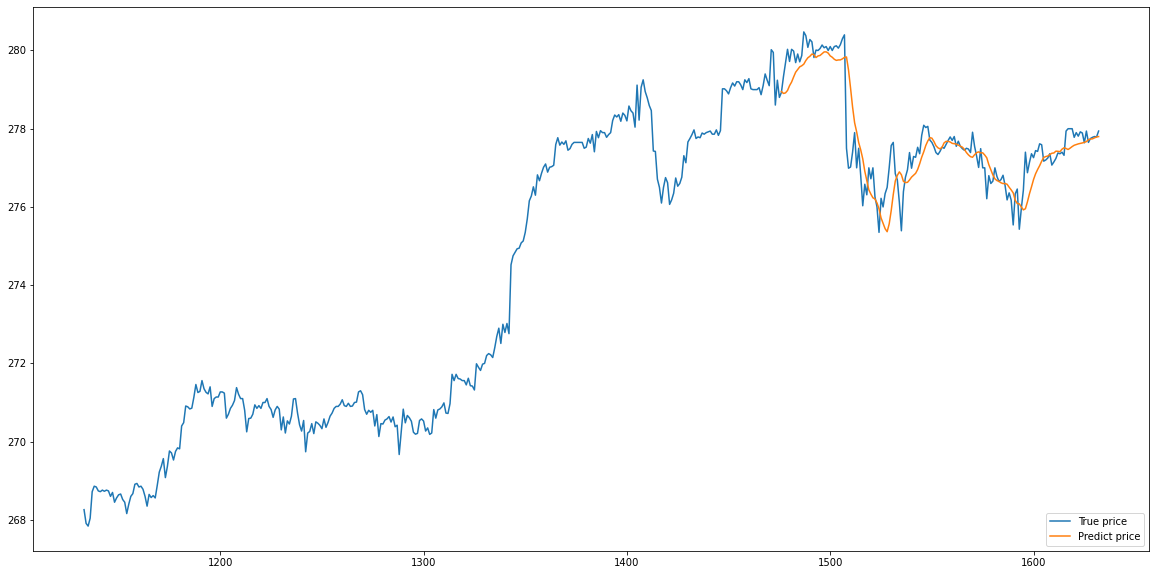

In [781]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-500:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

#### + RSI

#### + BBANDS

### Predict Future

In [851]:
def calculate_indicator_roc(data, current):
    return ((current[0] - data[19][0]) / (data[19][0])) * 100

In [871]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

In [ ]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = '../MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    
    numDataPoint = int(period / 15)
    
#     indicatorArr.insert(0, 'close')
    
    predictionArr = []

    data = data[indicatorArr].values

    for i in range(0, numDataPoint):
        data = data[-60:]
        
        scaler = MinMaxScaler(feature_range=(0,1))
        scaledData = scaler.fit_transform(data)

        modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

        predictedScaledValue = model.predict(modelInput)
        
        predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
        predictionArr.append(predictedValue[0])
        
        calculatedIndicatorArr = []
        for indicator in indicatorArr:
            cal = 0
            if indicator == 'ROC':
                cal = calculate_indicator_roc(data, predictedValue)
#             elif indicator == 'SMA':
#                 cal =calculate_indicator_sma(data, predictedValue)
#             elif indicator == 'RSI':
#                 cal = calculate_indicator_rsi(data, predictedValue)
#             elif indicator == 'BBANDS':
#                 cal = calculate_indicator_bbands(data, predictedValue)
            else:
                continue
            calculatedIndicatorArr.append(cal)
        calculatedIndicatorArr.insert(0, predictedValue[0])
        newRow = calculatedIndicatorArr
        data = np.append(data, [newRow], axis=0)
    return predictionArr

## 2. RNN

### Prepare Input

In [797]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[248.88],
       [248.64],
       [248.69],
       ...,
       [277.8 ],
       [277.79],
       [277.94]])

In [798]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645],
       [0.14742903],
       [0.14876808],
       ...,
       [0.92836101],
       [0.9280932 ],
       [0.93211034]])

In [799]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [800]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 1)
Size validate:  (157, 60, 1)
Size test:  (157, 60, 1)


### Train Model

In [801]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25
40/40 [==============================] - 11s 137ms/step - loss: 0.0587 - val_loss: 0.0055
Epoch 2/25
40/40 [==============================] - 4s 92ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 3/25
40/40 [==============================] - 4s 94ms/step - loss: 0.0033 - val_loss: 0.0087
Epoch 4/25
40/40 [==============================] - 4s 96ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 5/25
40/40 [==============================] - 4s 100ms/step - loss: 0.0028 - val_loss: 0.0077
Epoch 6/25
40/40 [==============================] - 4s 102ms/step - loss: 0.0028 - val_loss: 0.0106
Epoch 7/25
40/40 [==============================] - 4s 104ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/25
40/40 [==============================] - 5s 113ms/step - loss: 0.0026 - val_loss: 6.7562e-04
Epoch 9/25
40/40 [==============================] - 5s 127ms/step - loss: 0.0029 - val_loss: 0.0055
Epoch 10/25
40/40 [==============================] - 5s 119ms/step - loss: 0.0024 - val_loss: 0.00

### Test Model

In [802]:
model_rnn = load_model('./MODEL/RNN.h5')

In [803]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [804]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-804-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Upper Band,Real Lower Band,predictions
1476,2021-07-07 11:30:00,278.8400,278.97,278.5500,278.9300,624508.0,-0.0681,279.1518,51.1594,279.1518,279.8108,278.4927,278.632050
1477,2021-07-07 11:45:00,278.9450,279.35,278.5200,279.3314,570070.0,0.1188,279.1683,54.7801,279.1683,279.8279,278.5087,278.644562
1478,2021-07-07 12:00:00,279.3200,279.98,279.3200,279.6900,510257.0,0.1576,279.1903,57.7271,279.1903,279.8876,278.4930,278.653015
1479,2021-07-07 12:15:00,279.7050,280.23,279.6600,280.0300,527682.0,0.3045,279.2328,60.3087,279.2328,280.0202,278.4454,278.659637
1480,2021-07-07 12:30:00,280.0500,280.24,279.7000,279.7200,661221.0,0.1575,279.2548,56.9696,279.2548,280.0703,278.4393,278.668152
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,2021-07-09 19:00:00,277.7499,277.75,277.7499,277.7500,1611.0,0.1406,277.6570,53.8171,277.6570,278.2674,277.0466,277.355835
1629,2021-07-09 19:15:00,277.7800,277.78,277.7800,277.7800,220.0,0.2563,277.6925,54.1876,277.6925,278.2418,277.1432,277.382202
1630,2021-07-09 19:30:00,277.7900,277.80,277.7900,277.8000,1053.0,0.2345,277.7250,54.4440,277.7250,278.2159,277.2341,277.403137
1631,2021-07-09 19:45:00,277.8000,277.80,277.7900,277.7900,1233.0,0.1984,277.7525,54.2841,277.7525,278.1904,277.3146,277.419037


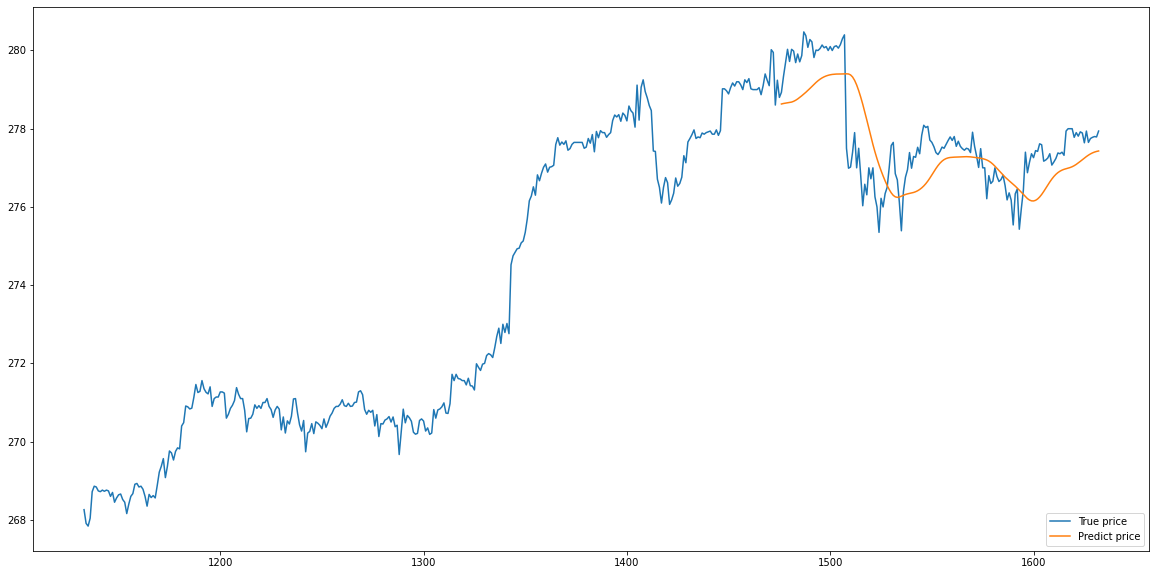

In [805]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-500:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Combine Indicators

#### + ROC

In [806]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 2.4888e+02, -9.1170e-01],
       [ 2.4864e+02, -8.7310e-01],
       [ 2.4869e+02, -9.1640e-01],
       ...,
       [ 2.7780e+02,  2.3450e-01],
       [ 2.7779e+02,  1.9840e-01],
       [ 2.7794e+02,  2.0190e-01]])

In [807]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645, 0.21469751],
       [0.14742903, 0.22363455],
       [0.14876808, 0.21360932],
       ...,
       [0.92836101, 0.48007687],
       [0.9280932 , 0.47171865],
       [0.93211034, 0.472529  ]])

In [808]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [810]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 2)
Size validate:  (157, 60, 2)
Size test:  (157, 60, 2)


In [811]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

Epoch 1/25
40/40 [==============================] - 12s 142ms/step - loss: 0.0641 - val_loss: 0.0147
Epoch 2/25
40/40 [==============================] - 4s 102ms/step - loss: 0.0042 - val_loss: 0.0091
Epoch 3/25
40/40 [==============================] - 4s 104ms/step - loss: 0.0034 - val_loss: 0.0092
Epoch 4/25
40/40 [==============================] - 4s 107ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 5/25
40/40 [==============================] - 4s 108ms/step - loss: 0.0029 - val_loss: 0.0086
Epoch 6/25
40/40 [==============================] - 4s 110ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 7/25
40/40 [==============================] - 4s 111ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 8/25
40/40 [==============================] - 5s 114ms/step - loss: 0.0026 - val_loss: 9.0057e-04
Epoch 9/25
40/40 [==============================] - 5s 127ms/step - loss: 0.0028 - val_loss: 0.0080
Epoch 10/25
40/40 [==============================] - 6s 142ms/step - loss: 0.0028 - val_loss: 0

In [812]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [813]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]
predictions

array([278.9526 , 278.90106, 278.91586, 278.97742, 279.101  , 279.19275,
       279.32306, 279.4451 , 279.51486, 279.58188, 279.6094 , 279.6507 ,
       279.74307, 279.81348, 279.852  , 279.9089 , 279.8912 , 279.8198 ,
       279.86014, 279.87308, 279.91776, 279.96304, 279.9652 , 279.93335,
       279.8621 , 279.82687, 279.77533, 279.74728, 279.75833, 279.7594 ,
       279.78644, 279.82474, 279.834  , 279.5006 , 279.0396 , 278.55206,
       278.15228, 277.91806, 277.64542, 277.45828, 277.2308 , 276.9138 ,
       276.66895, 276.43552, 276.32697, 276.2336 , 276.20425, 276.10205,
       275.95218, 275.71985, 275.57843, 275.44363, 275.36688, 275.56445,
       275.90765, 276.31418, 276.66293, 276.806  , 276.8965 , 276.82388,
       276.65347, 276.62326, 276.6284 , 276.68976, 276.7622 , 276.81033,
       276.85913, 276.95706, 277.1036 , 277.27252, 277.41034, 277.5711 ,
       277.68738, 277.7708 , 277.75888, 277.67468, 277.5667 , 277.5115 ,
       277.48462, 277.52243, 277.63757, 277.67734, 

In [814]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-814-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Upper Band,Real Lower Band,predictions
1476,2021-07-07 11:30:00,278.8400,278.97,278.5500,278.9300,624508.0,-0.0681,279.1518,51.1594,279.1518,279.8108,278.4927,278.952606
1477,2021-07-07 11:45:00,278.9450,279.35,278.5200,279.3314,570070.0,0.1188,279.1683,54.7801,279.1683,279.8279,278.5087,278.901062
1478,2021-07-07 12:00:00,279.3200,279.98,279.3200,279.6900,510257.0,0.1576,279.1903,57.7271,279.1903,279.8876,278.4930,278.915863
1479,2021-07-07 12:15:00,279.7050,280.23,279.6600,280.0300,527682.0,0.3045,279.2328,60.3087,279.2328,280.0202,278.4454,278.977417
1480,2021-07-07 12:30:00,280.0500,280.24,279.7000,279.7200,661221.0,0.1575,279.2548,56.9696,279.2548,280.0703,278.4393,279.101013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,2021-07-09 19:00:00,277.7499,277.75,277.7499,277.7500,1611.0,0.1406,277.6570,53.8171,277.6570,278.2674,277.0466,277.735382
1629,2021-07-09 19:15:00,277.7800,277.78,277.7800,277.7800,220.0,0.2563,277.6925,54.1876,277.6925,278.2418,277.1432,277.740936
1630,2021-07-09 19:30:00,277.7900,277.80,277.7900,277.8000,1053.0,0.2345,277.7250,54.4440,277.7250,278.2159,277.2341,277.766541
1631,2021-07-09 19:45:00,277.8000,277.80,277.7900,277.7900,1233.0,0.1984,277.7525,54.2841,277.7525,278.1904,277.3146,277.788818


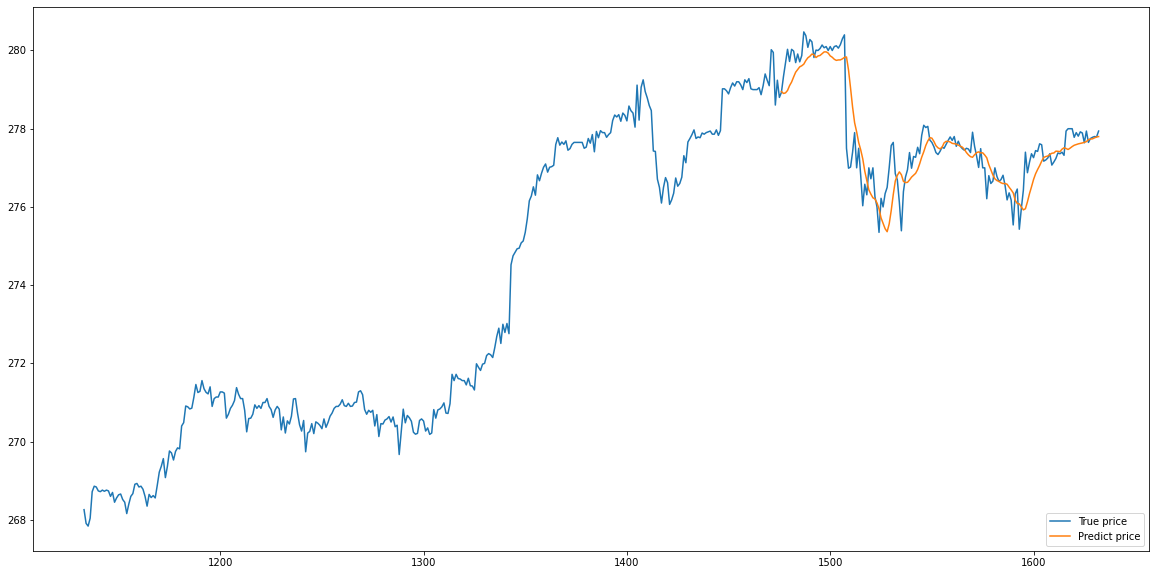

In [815]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-500:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### Prepare Input

In [244]:
dataset = original_df[["close"]]
dataset

,close
0,251.00
1,251.14
2,251.12
3,251.54
4,251.67
...,...
1619,277.49
1620,277.45
1621,277.50
1622,277.48


In [245]:
for i in range (1, 61):
    dataset["date_" + str(i)] = dataset.close.shift(i)
dataset

<ipython-input-245-04a71c557bd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["date_" + str(i)] = dataset.close.shift(i)


,close,date_1,date_2,date_3,date_4,date_5,date_6,date_7,date_8,date_9,...,date_51,date_52,date_53,date_54,date_55,date_56,date_57,date_58,date_59,date_60
0,251.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,251.14,251.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,251.12,251.14,251.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,251.54,251.12,251.14,251.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,251.67,251.54,251.12,251.14,251.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,277.49,277.55,277.68,277.55,277.80,277.70,277.79,277.70,277.60,277.50,...,277.50,277.00,277.90,277.4,277.02,276.99,277.50,280.40,280.30,280.15
1620,277.45,277.49,277.55,277.68,277.55,277.80,277.70,277.79,277.70,277.60,...,276.80,277.50,277.00,277.9,277.40,277.02,276.99,277.50,280.40,280.30
1621,277.50,277.45,277.49,277.55,277.68,277.55,277.80,277.70,277.79,277.70,...,276.03,276.80,277.50,277.0,277.90,277.40,277.02,276.99,277.50,280.40
1622,277.48,277.50,277.45,277.49,277.55,277.68,277.55,277.80,277.70,277.79,...,276.58,276.03,276.80,277.5,277.00,277.90,277.40,277.02,276.99,277.50


In [246]:
dataset.dropna(inplace=True)
dataset

,close,date_1,date_2,date_3,date_4,date_5,date_6,date_7,date_8,date_9,...,date_51,date_52,date_53,date_54,date_55,date_56,date_57,date_58,date_59,date_60
60,248.31,248.51,248.12,247.95,248.69,248.64,248.88,250.0175,249.9968,251.2100,...,251.18,251.54,251.61,251.756,251.940,251.670,251.540,251.120,251.14,251.00
61,248.33,248.31,248.51,248.12,247.95,248.69,248.64,248.8800,250.0175,249.9968,...,250.85,251.18,251.54,251.610,251.756,251.940,251.670,251.540,251.12,251.14
62,248.00,248.33,248.31,248.51,248.12,247.95,248.69,248.6400,248.8800,250.0175,...,250.89,250.85,251.18,251.540,251.610,251.756,251.940,251.670,251.54,251.12
63,248.22,248.00,248.33,248.31,248.51,248.12,247.95,248.6900,248.6400,248.8800,...,250.81,250.89,250.85,251.180,251.540,251.610,251.756,251.940,251.67,251.54
64,248.09,248.22,248.00,248.33,248.31,248.51,248.12,247.9500,248.6900,248.6400,...,250.70,250.81,250.89,250.850,251.180,251.540,251.610,251.756,251.94,251.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,277.49,277.55,277.68,277.55,277.80,277.70,277.79,277.7000,277.6000,277.5000,...,277.50,277.00,277.90,277.400,277.020,276.990,277.500,280.400,280.30,280.15
1620,277.45,277.49,277.55,277.68,277.55,277.80,277.70,277.7900,277.7000,277.6000,...,276.80,277.50,277.00,277.900,277.400,277.020,276.990,277.500,280.40,280.30
1621,277.50,277.45,277.49,277.55,277.68,277.55,277.80,277.7000,277.7900,277.7000,...,276.03,276.80,277.50,277.000,277.900,277.400,277.020,276.990,277.50,280.40
1622,277.48,277.50,277.45,277.49,277.55,277.68,277.55,277.8000,277.7000,277.7900,...,276.58,276.03,276.80,277.500,277.000,277.900,277.400,277.020,276.99,277.50


In [247]:
X = dataset.drop('close', 1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1564, 60)
(1564, 1)


array([[248.51, 248.12, 247.95, ..., 251.12, 251.14, 251.  ],
       [248.31, 248.51, 248.12, ..., 251.54, 251.12, 251.14],
       [248.33, 248.31, 248.51, ..., 251.67, 251.54, 251.12],
       ...,
       [277.45, 277.49, 277.55, ..., 276.99, 277.5 , 280.4 ],
       [277.5 , 277.45, 277.49, ..., 277.02, 276.99, 277.5 ],
       [277.48, 277.5 , 277.45, ..., 277.4 , 277.02, 276.99]])

In [248]:
X_train, y_train = X[:math.ceil(len(X)*0.8)], y[:math.ceil(len(X)*0.8)]
X_val, y_val = X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)], y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1252, 60)
Size validate:  (156, 60)
Size test:  (156, 60)


### Train Model

In [249]:
import xgboost

In [250]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           learning_rate=0.08, 
                           gamma=0, 
                           subsample=0.75, 
                           colsample_bytree=1, 
                           max_depth=8, 
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
model.save_model("XGBOOST.h5")

### Test Model

In [260]:
# model_xgboost = load_model("XGBOOST.h5")

In [261]:
predictions = model.predict(X_test)
# arr = []
# for i in range(len(predictions)):
#   arr.append([predictions[i]])
# predictions = arr
# predictions=scaler.inverse_transform(predictions)
predictions

array([270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1636,
       270.1636, 270.1636, 270.1636, 270.1636, 270.1636, 270.1

In [262]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-262-88868e85d37d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,close,date_1,date_2,date_3,date_4,date_5,date_6,date_7,date_8,date_9,...,date_52,date_53,date_54,date_55,date_56,date_57,date_58,date_59,date_60,predictions
1468,277.42,277.43,278.465,278.5925,278.7900,278.9500,279.2500,279.0600,278.2199,279.1150,...,277.015,276.890,277.0984,277.0150,276.8600,276.6700,276.8200,276.300,276.5142,270.163605
1469,276.71,277.42,277.430,278.4650,278.5925,278.7900,278.9500,279.2500,279.0600,278.2199,...,277.030,277.015,276.8900,277.0984,277.0150,276.8600,276.6700,276.820,276.3000,270.163605
1470,276.50,276.71,277.420,277.4300,278.4650,278.5925,278.7900,278.9500,279.2500,279.0600,...,277.065,277.030,277.0150,276.8900,277.0984,277.0150,276.8600,276.670,276.8200,270.163605
1471,276.10,276.50,276.710,277.4200,277.4300,278.4650,278.5925,278.7900,278.9500,279.2500,...,277.595,277.065,277.0300,277.0150,276.8900,277.0984,277.0150,276.860,276.6700,270.163605
1472,276.50,276.10,276.500,276.7100,277.4200,277.4300,278.4650,278.5925,278.7900,278.9500,...,277.770,277.595,277.0650,277.0300,277.0150,276.8900,277.0984,277.015,276.8600,270.163605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,277.49,277.55,277.680,277.5500,277.8000,277.7000,277.7900,277.7000,277.6000,277.5000,...,277.000,277.900,277.4000,277.0200,276.9900,277.5000,280.4000,280.300,280.1500,270.163605
1620,277.45,277.49,277.550,277.6800,277.5500,277.8000,277.7000,277.7900,277.7000,277.6000,...,277.500,277.000,277.9000,277.4000,277.0200,276.9900,277.5000,280.400,280.3000,270.163605
1621,277.50,277.45,277.490,277.5500,277.6800,277.5500,277.8000,277.7000,277.7900,277.7000,...,276.800,277.500,277.0000,277.9000,277.4000,277.0200,276.9900,277.500,280.4000,270.163605
1622,277.48,277.50,277.450,277.4900,277.5500,277.6800,277.5500,277.8000,277.7000,277.7900,...,276.030,276.800,277.5000,277.0000,277.9000,277.4000,277.0200,276.990,277.5000,270.163605


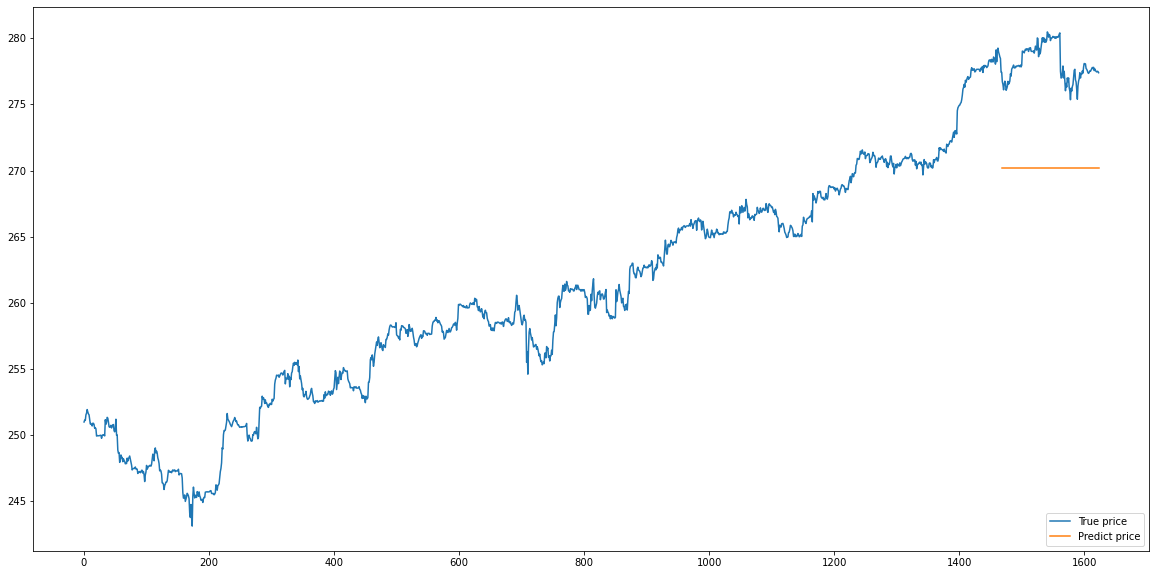

In [263]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

# XGBOOST's SECOND ATTEMPT

### Prepare Input

In [366]:
dataset = original_df[["close"]]
dataset["target"] = dataset.close.shift(-1)
dataset.dropna(inplace=True)
dataset

<ipython-input-366-43f4cea4d7af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["target"] = dataset.close.shift(-1)
<ipython-input-366-43f4cea4d7af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


,close,target
0,251.00,251.14
1,251.14,251.12
2,251.12,251.54
3,251.54,251.67
4,251.67,251.94
...,...,...
1618,277.55,277.49
1619,277.49,277.45
1620,277.45,277.50
1621,277.50,277.48


In [367]:
X = pd.DataFrame(dataset['close'])
y = pd.DataFrame(dataset['target'])
print(X.shape)
print(y.shape)

(1623, 1)
(1623, 1)


In [368]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1461, 1)
Size test:  (162, 1)


### Train Model

In [369]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           learning_rate=0.08, 
                           gamma=0, 
                           subsample=0.75, 
                           colsample_bytree=1, 
                           max_depth=8, 
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
model.save_model("./MODEL/XGBOOST.json")

### Test Model 

In [370]:
model_xgboost = model # load model

In [371]:
def validate(X_test):
    predictions = []
    X_test = X_test.values
    for i in range(len(X_test)):
        pred = model_xgboost.predict(X_test[i])
        predictions.append(pred[0])
    return predictions
predictions = validate(X_test)

In [372]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-372-88868e85d37d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,close,target,predictions
1461,279.0600,279.2500,278.132629
1462,279.2500,278.9500,278.132629
1463,278.9500,278.7900,278.132629
1464,278.7900,278.5925,278.174896
1465,278.5925,278.4650,278.174896
...,...,...,...
1618,277.5500,277.4900,277.571289
1619,277.4900,277.4500,277.522217
1620,277.4500,277.5000,277.511780
1621,277.5000,277.4800,277.522217


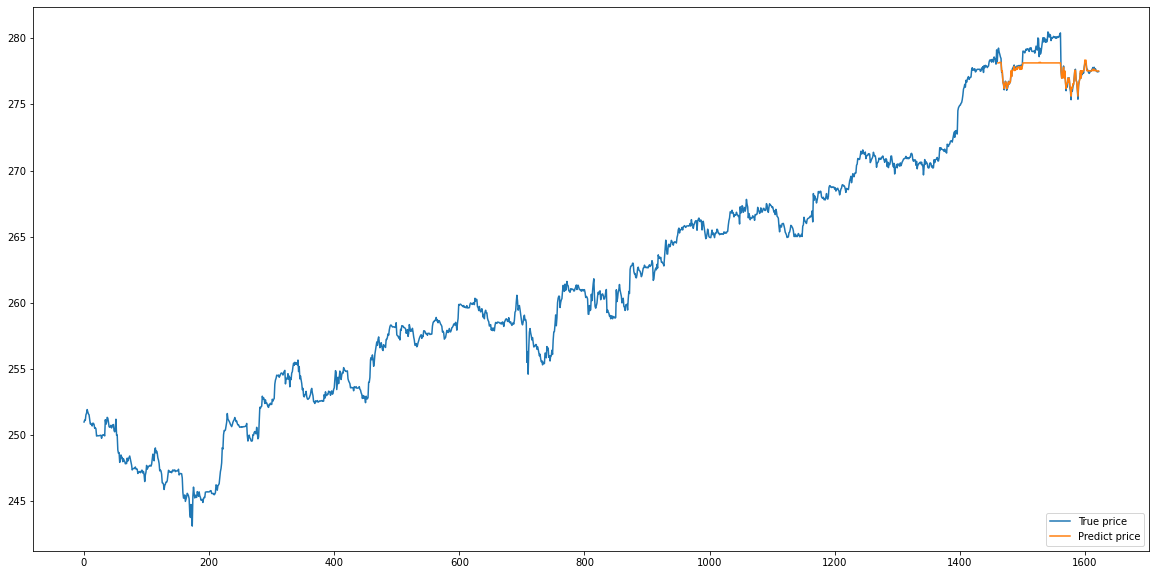

In [373]:
plt.figure(figsize = (20, 10))
plt.plot(dataset['close'])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Combine Indicators

#### + ROC

In [374]:
dataset = original_df[["close", "ROC"]]
dataset["target"] = dataset.close.shift(-1)
dataset.dropna(inplace=True)
dataset

<ipython-input-374-bb4b9afb0fe8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["target"] = dataset.close.shift(-1)
<ipython-input-374-bb4b9afb0fe8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


,close,ROC,target
0,251.00,0.2116,251.14
1,251.14,0.3837,251.12
2,251.12,0.3276,251.54
3,251.54,0.3751,251.67
4,251.67,0.4270,251.94
...,...,...,...
1618,277.55,0.0685,277.49
1619,277.49,-0.1224,277.45
1620,277.45,-0.2295,277.50
1621,277.50,-0.1906,277.48


In [376]:
X = dataset.drop('target', 1)
y = pd.DataFrame(dataset['target'])
print(X.shape)
print(y.shape)

(1623, 2)
(1623, 1)


In [377]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1461, 2)
Size test:  (162, 2)


In [378]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           learning_rate=0.08, 
                           gamma=0, 
                           subsample=0.75, 
                           colsample_bytree=1, 
                           max_depth=8, 
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
model.save_model("./MODEL/XGBOOST_ROC.json")

In [379]:
model_xgboost = model # load model

In [380]:
def validate(X_test):
    predictions = []
    X_test = X_test.values
    for i in range(len(X_test)):
        pred = model_xgboost.predict(X_test[i])
        predictions.append(pred[0])
    return predictions
predictions = validate(X_test)

XGBoostError: [10:56:07] /Users/travis/build/dmlc/xgboost/src/predictor/cpu_predictor.cc:258: Check failed: m->NumColumns() == model.learner_model_param->num_feature (1 vs. 2) : Number of columns in data must equal to trained model.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000146217de4 dmlc::LogMessageFatal::~LogMessageFatal() + 116
  [bt] (1) 2   libxgboost.dylib                    0x000000014633352d void xgboost::predictor::CPUPredictor::DispatchedInplacePredict<xgboost::data::ArrayAdapter>(dmlc::any const&, std::__1::shared_ptr<xgboost::DMatrix>, xgboost::gbm::GBTreeModel const&, float, xgboost::PredictionCacheEntry*, unsigned int, unsigned int) const + 365
  [bt] (2) 3   libxgboost.dylib                    0x000000014632f861 xgboost::predictor::CPUPredictor::InplacePredict(dmlc::any const&, std::__1::shared_ptr<xgboost::DMatrix>, xgboost::gbm::GBTreeModel const&, float, xgboost::PredictionCacheEntry*, unsigned int, unsigned int) const + 401
  [bt] (3) 4   libxgboost.dylib                    0x00000001462b66c8 xgboost::gbm::GBTree::InplacePredict(dmlc::any const&, std::__1::shared_ptr<xgboost::DMatrix>, float, xgboost::PredictionCacheEntry*, unsigned int, unsigned int) const + 424
  [bt] (4) 5   libxgboost.dylib                    0x00000001462cb14b xgboost::LearnerImpl::InplacePredict(dmlc::any const&, std::__1::shared_ptr<xgboost::DMatrix>, xgboost::PredictionType, float, xgboost::HostDeviceVector<float>**, unsigned int, unsigned int) + 123
  [bt] (5) 6   libxgboost.dylib                    0x00000001462118cb void InplacePredictImpl<xgboost::data::ArrayAdapter>(std::__1::shared_ptr<xgboost::data::ArrayAdapter>, std::__1::shared_ptr<xgboost::DMatrix>, char const*, xgboost::Learner*, unsigned long, unsigned long, unsigned long long const**, unsigned long long*, float const**) + 843
  [bt] (6) 7   libxgboost.dylib                    0x0000000146211253 XGBoosterPredictFromDense + 339
  [bt] (7) 8   libffi.7.dylib                      0x0000000106d54ead ffi_call_unix64 + 85

